# Benchmark your Poppy robot

The goal of this notebook is to help you identify the performance of your robot and where the bottle necks are. We will measure:
* the time to read/write the position to one motor (for each of your dynamixel bus)
* the time to read/write the positions for all motors (for each of your dynamixel bus)
* the regularity of the synchronization loop of pos/speed/load when
    * only this loop is runnnig
    * all other synchronization loops are running
    * everything else is running

In [1]:
from __future__ import print_function, division

from ipywidgets import interact

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


All bench info will be stored in this dictionary so it's easy to compare with other platforms.

In [3]:
results = {}

## What's the platform

In [4]:
import platform

p = platform.platform()
print(p)

results['platform'] = p

Linux-4.1.19-v7+-armv7l-with-debian-8.0


In [5]:
import sys

v = sys.version
print(v)

results['python'] = v

2.7.10 |Continuum Analytics, Inc.| (default, Oct 28 2015, 19:48:38) 
[GCC 4.6.3]


In [6]:
import pypot
import poppy.creatures

results['pypot'] = pypot.__version__
print('Pypot version: {}'.format(results['pypot']))

results['poppy-creature'] = poppy.creatures.__version__
print('Poppy-creature version: {}'.format(results['poppy-creature']))

Pypot version: 2.11.5
Poppy-creature version: 1.8.1


In [7]:
from poppy.creatures import installed_poppy_creatures

RobotCls = None

def robot_selector(robot):
    global RobotCls
    RobotCls = robot
    
interact(robot_selector, robot=installed_poppy_creatures);

In [8]:
robot = RobotCls()
results['robot'] = RobotCls

Make sure all motors are turned off to avoid breaking anything:

In [9]:
for m in robot.motors:
    m.compliant = True

We find the synchronization loop for pos/speed/load and monkey patch them for monitoring.

In [10]:
import time

from pypot.dynamixel.syncloop import MetaDxlController
from pypot.dynamixel.controller import PosSpeedLoadDxlController

meta_controllers = [c for c in robot._controllers if isinstance(c, MetaDxlController)]
controllers = [cc for cc in c.controllers for c in meta_controllers if isinstance(cc, PosSpeedLoadDxlController)]

for c in controllers:
    c.stop()

for c in controllers:    
    def wrapped_update():
        if not hasattr(c, 't'):
            c.t = []
            
        c.t.append(time.time())
        c.update()
        
    c._update = wrapped_update
    

for c in controllers:
    c.start()

Now, we define our monitor and plotting functions.

In [11]:
import psutil

def monitor(controllers, duration):
    for c in controllers:
        c.stop()
        c.t = []
        c.start()
        
    cpu = []
    start = time.time()
    while time.time() - start < duration:
        time.sleep(1.0)
    cpu.append(psutil.cpu_percent())
        
    print('Avg CPU usage: {}%'.format(mean(cpu)))
    return {c: array(c.t) for c in controllers}

def freq_plot(logs):
    for c, t in logs.items():
        dt = diff(t)
        freq = 1.0 / dt
        
        print('Avg frq for controller {}: {}ms STD={}ms'.format(c.ids, freq.mean(), freq.std()))
        hist(freq)
        xlim(0, 100)

We also define this follow trajectory function, which applies a sinus on one motor (choosen below) and plot how close is its real position from the target one:

In [12]:
def follow_trajectory(motor, duration=5, freq=50):
    t = linspace(0, duration, duration * freq)

    a1, f1 = 10.0, 1.0
    a2, f2 = 5.0, 0.5

    traj = a1 * sin(2 * pi * f1 * t) + a2 * sin(2 * pi * f2 * t)
    rec = []


    motor.compliant = False
    motor.moving_speed = 0
    motor.goal_position = 0
    time.sleep(1.)

    for p in traj:
        motor.goal_position = p
        rec.append(motor.present_position)

        time.sleep(1.0 / freq)    
        
    motor.compliant = True

    plot(traj)
    plot(rec)    

Now choose which motor you want to use for the follow trajectory test. It should be able to move freely from -20 to +20 degrees.

In [13]:
motor = None

def motor_selector(m):
    global motor
    motor = getattr(robot, m)
    
interact(motor_selector, m=[m.name for m in robot.motors]);

## Benchmark

Our benchmark duration in seconds:

In [14]:
duration = 30

### Normal usage

Avg CPU usage: 17.0%
Avg frq for controller [1, 2, 3, 4, 5, 6]: 49.1493342343ms STD=2.53030421378ms


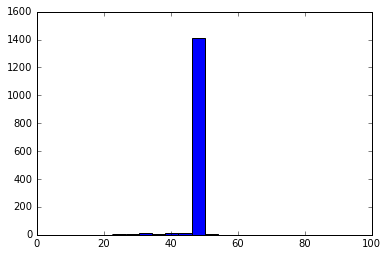

In [15]:
d = monitor(controllers, duration)
freq_plot(d)

results['normal'] = d

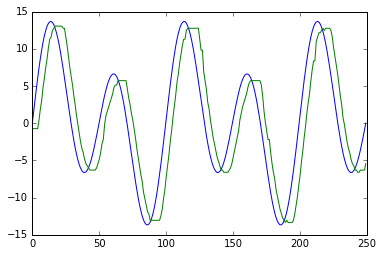

In [16]:
follow_trajectory(motor)

### Without primitives

In [17]:
for p in robot.primitives:
    p.stop()
    
robot._primitive_manager.stop()

Avg CPU usage: 18.3%
Avg frq for controller [1, 2, 3, 4, 5, 6]: 49.1257827327ms STD=2.43625545718ms


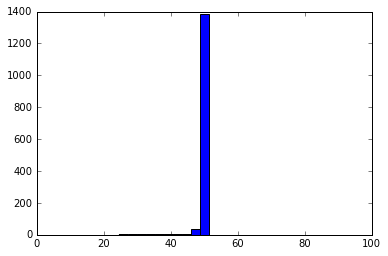

In [18]:
d = monitor(controllers, duration)
freq_plot(d)

results['without primitive'] = d

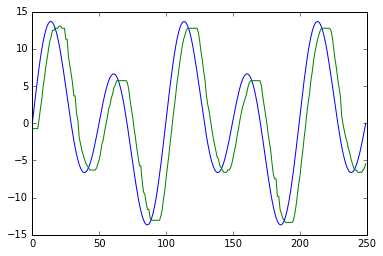

In [19]:
follow_trajectory(motor)

### Without all sensors

In [ ]:
for s in robot.sensors:
    s.close()

In [ ]:
d = monitor(controllers, duration)
freq_plot(d)

results['without sensor'] = d

In [ ]:
follow_trajectory(motor)